In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load Data

Upload the files to your Google Drive and mount it in the Colab notebook using the code below.

Files: `promos.csv.gz`, `test_history.csv.gz`, `train_history.csv.gz`, and `transactions.csv.gz`.

In [ ]:
# This will ask you to give Colab permission to access your Google Drive
# and enter an authorization code.
# See: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# MODIFY THIS LINE with the path to where you saved the datafiles on your Google drive
path = '/content/drive/My Drive/RSM 8521 - Assignment 3'

In [ ]:
promos = pd.read_csv(path + '/promos.csv.gz')
promos.head()

,promo,category,promoqty,manufacturer,promoval,brand
0,209524,51006740,1,1593002228,1.00,189092190
1,176321,42760698,1,1957688344,0.75,1386413202
2,17125,56844954,1,629075831,1.50,1429623935
3,177412,56844954,1,629075831,1.50,1429623935
4,69839,56844954,1,629075831,1.50,1429623935


In [ ]:
train_history = pd.read_csv(path + '/train_history.csv.gz', parse_dates=['promodate'])
train_history.head()

,id,store,promo,region,promodate,active
0,115562959531,860548,176321,243820,2013-03-25,0.0
1,175261390705,625933,37568,191747,2013-03-15,0.0
2,273751574633,527828,209524,165933,2013-03-23,1.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0
4,135410903443,241369,176321,278897,2013-03-25,0.0


In [ ]:
test_history = pd.read_csv(path + '/test_history.csv.gz', parse_dates=['promodate'])
test_history.head()

,id,store,promo,region,promodate,active
0,250462324156,457755,96852,191747,2013-04-22,NaN
1,61214568335,740794,54956,203586,2013-04-23,NaN
2,274776763999,394092,95011,42773,2013-04-02,NaN
3,91546215019,876095,108237,323706,2013-04-24,NaN
4,220718580189,625933,222088,191747,2013-04-18,NaN


In [ ]:
# load productsize and amt columns as float32 to reduce memory footprint
transactions = pd.read_csv(path + '/transactions.csv.gz',
                           parse_dates=['date'],
                           dtype={'productsize': 'float32',
                                  'amt': 'float32'})
transactions['month'] = transactions['date'].dt.month
transactions['quarter'] = transactions['date'].dt.quarter
transactions['day'] = transactions['date'].dt.day
transactions['weekday'] = transactions['date'].dt.weekday
transactions['day_type'] = transactions['date'].dt.dayofweek.apply(lambda x: 'weekend' if x >= 5 else 'weekday')
transactions['cat_info'] = transactions['category'].isin(promos['category']).astype(int)
transactions.head(5)

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt,month,quarter,day,weekday,day_type,cat_info
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69,3,1,6,1,weekday,0
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48,3,1,6,1,weekday,0
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69,3,1,6,1,weekday,0
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41,3,1,6,1,weekday,0
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19,3,1,6,1,weekday,0


In [ ]:
import pandas as pd
month_counts = transactions.groupby(['id', 'month']).size().unstack(fill_value=0).add_prefix('month_')
month_binary = (month_counts > 0).astype(int)  # Convert to binary (1 for orders present, 0 for no orders)
quarter_counts = transactions.groupby(['id', 'quarter']).size().unstack(fill_value=0).add_prefix('quarter_')
quarter_binary = (quarter_counts > 0).astype(int)  # Convert to binary

print(month_binary.head(5))
print(quarter_binary.head(5))

month     month_1  month_2  month_3  month_4  month_5  month_6  month_7  \
id                                                                        
32159355        1        1        1        1        1        1        1   
38085541        1        1        1        1        1        1        1   
41697872        1        1        1        1        1        1        1   
54676900        1        1        1        1        1        1        1   
58631253        1        1        1        1        1        1        1   

month     month_8  month_9  month_10  month_11  month_12  
id                                                        
32159355        1        1         1         1         1  
38085541        1        1         1         1         1  
41697872        1        1         1         1         1  
54676900        1        1         1         1         1  
58631253        1        1         1         1         1  
quarter   quarter_1  quarter_2  quarter_3  quarter_4
id      

In [ ]:
day_type_mapping = {'weekday': 0, 'weekend': 1}
transactions['day_type'] = transactions['day_type'].map(day_type_mapping)
transactions.head(5)

,id,store,market_group,category,manufacturer,brand,date,productsize,measure,qty,amt,month,quarter,day,weekday,day_type,cat_info
0,31924309471,96431,360548,10881580,707582354,109487351,2012-03-06,28.00,OZ,1,2.69,3,1,6,1,0,0
1,31924309471,96431,80472,75959720,2052533430,254982935,2012-03-06,12.00,OZ,2,8.48,3,1,6,1,0,0
2,31924309471,96431,194893,80209099,1640770606,1252530761,2012-03-06,6.00,OZ,1,1.69,3,1,6,1,0,0
3,31924309471,96431,27828,10942974,946555356,2133681340,2012-03-06,0.75,LT,1,11.41,3,1,6,1,0,0
4,31924309471,96431,135933,64737859,700393013,221618334,2012-03-06,33.84,OZ,1,3.19,3,1,6,1,0,0


In [ ]:
transactions.columns

Index(['id', 'store', 'market_group', 'category', 'manufacturer', 'brand',
       'date', 'productsize', 'measure', 'qty', 'amt', 'month', 'quarter',
       'day', 'weekday', 'day_type', 'cat_info'],
      dtype='object')

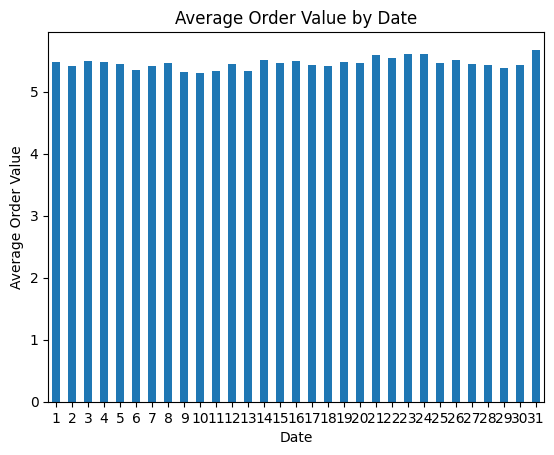

In [ ]:
average_order_value = transactions.groupby('day')['amt'].mean()

# Plot
average_order_value.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Average Order Value')
plt.title('Average Order Value by Date')
plt.xticks(rotation=0)
plt.show()

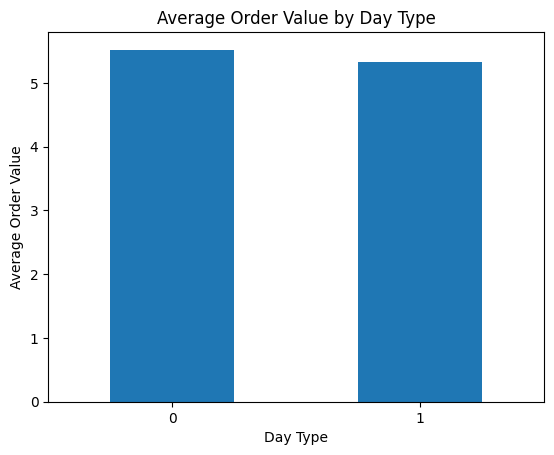

In [ ]:
average_order_value = transactions.groupby('day_type')['amt'].mean()

# Plot
average_order_value.plot(kind='bar')
plt.xlabel('Day Type')
plt.ylabel('Average Order Value')
plt.title('Average Order Value by Day Type')
plt.xticks(rotation=0)
plt.show()

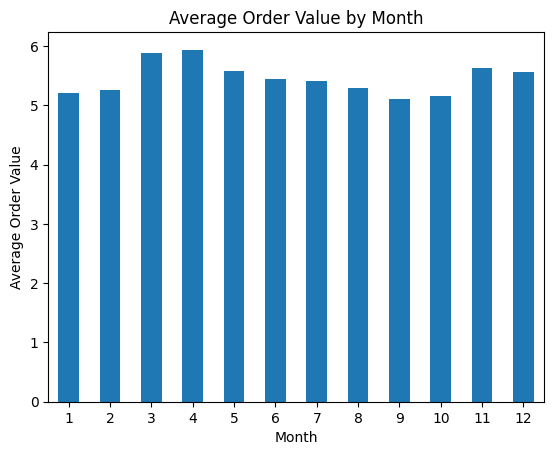

In [ ]:
average_order_value = transactions.groupby('month')['amt'].mean()

# Plot
average_order_value.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Order Value')
plt.title('Average Order Value by Month')
plt.xticks(rotation=0)
plt.show()

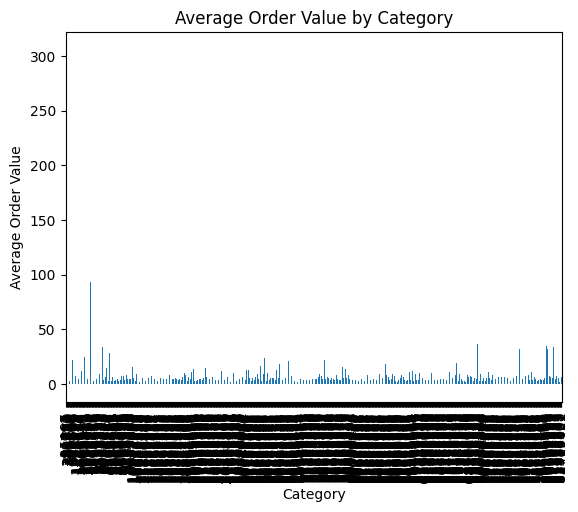

In [ ]:
brand_average_order_value = transactions.groupby('category')['amt'].mean()

# Plot
brand_average_order_value.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Average Order Value')
plt.title('Average Order Value by Category')
plt.xticks(rotation=90)
plt.show()


In [ ]:
transactions.day.unique()

array([ 6, 13, 18, 23,  1, 22, 29,  5, 21, 30, 12,  3, 15,  8,  7, 16,  2,
       25, 28,  9, 14, 26, 17, 11, 27,  4, 19, 10, 20, 24, 31],
      dtype=int32)

## Compute RFM Features

In [ ]:
promos.manufacturer.value_counts()

manufacturer
122801592     7
629075831     5
1154816776    2
266826345     2
324835488     2
1593002228    1
1957688344    1
1150283635    1
2037186963    1
376504989     1
107216507     1
Name: count, dtype: int64

In [ ]:
print(transactions.date.max())
print(transactions.date.min())

2013-02-28 00:00:00
2012-03-02 00:00:00


In [ ]:
max_date = transactions.date.max()
transactions['last_purchase'] = (max_date - transactions['date']) / np.timedelta64(1, "D")

# Agg transaction data to id
# Add a helper column for summing amounts by month and id
transactions['month_amt'] = transactions.groupby(['id', 'month'])['amt'].transform('sum')


# Agg transaction data to id
trans_features = transactions.groupby('id').agg({
    'last_purchase': 'min',
    'date': ['nunique', 'min','count'],
    'month':'nunique',
    'quarter': 'nunique',
    'amt': ['sum'],
    'category': 'nunique',
    'productsize': ['sum'],
    'qty': ['sum'],
    'market_group': 'nunique',
    'manufacturer': 'nunique',
    'day_type': 'mean',
    'cat_info': 'sum'
    # using the custom function for finding the peak spending month
})

# Compute RFM columns
trans_features['recency'] = trans_features['last_purchase']['min']
trans_features['frequency'] = (trans_features['date']['nunique']
                               / ((max_date - trans_features['date']['min']) / np.timedelta64(1, "D")))
trans_features['monetary'] = trans_features['amt']['sum']
trans_features['productsize'] = trans_features['productsize']['sum']
trans_features['qty'] = trans_features['qty']['sum']
trans_features['market_group'] = trans_features['market_group']['nunique']
trans_features['manufacturer'] = trans_features['manufacturer']['nunique']
trans_features['month'] = trans_features['month']['nunique']
trans_features['quarter'] = trans_features['quarter']['nunique']
trans_features['tot_ord'] = trans_features['date']['count']
trans_features['date_unique'] = trans_features['date']['nunique']
trans_features['day_type'] = trans_features['day_type']['mean']
trans_features['cat_info'] = trans_features['cat_info']['sum']
trans_features.head(5)

last_purchase    date                    month quarter          amt  \
                   min nunique        min count nunique nunique          sum   
id                                                                             
32159355           3.0      72 2012-03-07   642      12       4  3141.840088   
38085541           4.0      53 2012-03-04   607      12       4  2231.169922   
41697872           0.0      90 2012-03-03  1206      12       4  5006.520020   
54676900           0.0      88 2012-03-07   625      12       4  1793.020020   
58631253           0.0      91 2012-03-03  1185      12       4  4926.399902   

         category   productsize   qty market_group manufacturer  day_type  \
          nunique           sum   sum      nunique      nunique      mean   
id                                                                          
32159355      227  18738.289062   774           65          197  0.275701   
38085541      154  14346.860352   737           53          145  0.357496   
41697872      247  38108.359375  1719           66          284  0.657546   
54676900      111  15628.059570   841           48          101  0.132800   
58631253      246  35030.511719  1412           64          217  0.449789   

         cat_info recency frequency     monetary tot_ord date_unique  
              sum                                                     
id                                                                    
32159355       30     3.0  0.201117  3141.840088     642          72  
38085541       10     4.0  0.146814  2231.169922     607          53  
41697872       49     0.0  0.248619  5006.520020    1206          90  
54676900       13     0.0  0.245810  1793.020020     625          88  
58631253       12     0.0  0.251381  4926.399902    1185          91

In [ ]:
trans_features.head(5)

last_purchase    date                    month quarter          amt  \
                   min nunique        min count nunique nunique          sum   
id                                                                             
32159355           3.0      72 2012-03-07   642      12       4  3141.840088   
38085541           4.0      53 2012-03-04   607      12       4  2231.169922   
41697872           0.0      90 2012-03-03  1206      12       4  5006.520020   
54676900           0.0      88 2012-03-07   625      12       4  1793.020020   
58631253           0.0      91 2012-03-03  1185      12       4  4926.399902   

         category   productsize   qty market_group manufacturer  day_type  \
          nunique           sum   sum      nunique      nunique      mean   
id                                                                          
32159355      227  18738.289062   774           65          197  0.275701   
38085541      154  14346.860352   737           53          145  0.357496   
41697872      247  38108.359375  1719           66          284  0.657546   
54676900      111  15628.059570   841           48          101  0.132800   
58631253      246  35030.511719  1412           64          217  0.449789   

         cat_info recency frequency     monetary tot_ord date_unique  
              sum                                                     
id                                                                    
32159355       30     3.0  0.201117  3141.840088     642          72  
38085541       10     4.0  0.146814  2231.169922     607          53  
41697872       49     0.0  0.248619  5006.520020    1206          90  
54676900       13     0.0  0.245810  1793.020020     625          88  
58631253       12     0.0  0.251381  4926.399902    1185          91

In [ ]:
trans_features = trans_features[['recency', 'frequency', 'monetary', 'qty', 'productsize', 'market_group', 'month', 'quarter', 'tot_ord','date_unique','day_type']].reset_index()
trans_features.columns = trans_features.columns.get_level_values(0)
trans_features['recency'] = 356 - trans_features['recency']
trans_features = trans_features.join(month_counts, on='id', how='left')
trans_features = trans_features.join(quarter_counts, on='id', how='left')
trans_features.head(5)

,id,recency,frequency,monetary,qty,productsize,market_group,month,quarter,tot_ord,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,32159355,353.0,0.201117,3141.840088,774,18738.289062,65,12,4,642,...,44,66,45,72,58,77,120,160,155,207
1,38085541,352.0,0.146814,2231.169922,737,14346.860352,53,12,4,607,...,55,42,55,17,13,111,198,116,152,141
2,41697872,356.0,0.248619,5006.520020,1719,38108.359375,66,12,4,1206,...,110,65,97,108,125,157,333,211,272,390
3,54676900,356.0,0.245810,1793.020020,841,15628.059570,48,12,4,625,...,58,33,69,60,77,60,149,119,160,197
4,58631253,356.0,0.251381,4926.399902,1412,35030.511719,64,12,4,1185,...,109,113,78,74,99,149,284,279,300,322


In [ ]:
trans_features.columns

Index(['id', 'recency', 'frequency', 'monetary', 'qty', 'productsize',
       'market_group', 'month', 'quarter', 'tot_ord', 'date_unique',
       'day_type', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

## Generate train, test and prediction sets

In [ ]:
# Generate train/test features
features = train_history.merge(trans_features, on='id', how='left')
features.recency.fillna(365, inplace=True)
features.frequency.fillna(0, inplace=True)
features.monetary.fillna(0, inplace=True)
features.head(5)

,id,store,promo,region,promodate,active,recency,frequency,monetary,qty,...,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,115562959531,860548,176321,243820,2013-03-25,0.0,356.0,0.150000,2697.929932,948.0,...,40.0,81.0,48.0,39.0,81.0,56.0,190.0,163.0,169.0,176.0
1,175261390705,625933,37568,191747,2013-03-15,0.0,343.0,0.086835,1938.510010,870.0,...,35.0,80.0,0.0,33.0,81.0,82.0,180.0,102.0,115.0,196.0
2,273751574633,527828,209524,165933,2013-03-23,1.0,350.0,0.069277,420.440002,211.0,...,27.0,9.0,0.0,14.0,26.0,16.0,12.0,51.0,36.0,56.0
3,166923268906,1056730,214816,5506,2013-03-20,0.0,355.0,0.212885,3823.560059,1282.0,...,5.0,0.0,0.0,0.0,54.0,135.0,400.0,212.0,5.0,189.0
4,135410903443,241369,176321,278897,2013-03-25,0.0,354.0,0.146409,3787.260010,1531.0,...,127.0,133.0,24.0,81.0,111.0,142.0,254.0,307.0,284.0,334.0


In [ ]:
features = features.merge(promos, how='left', left_on='promo', right_on='promo')
features.head(5)

,id,store,promo,region,promodate,active,recency,frequency,monetary,qty,...,month_12,quarter_1,quarter_2,quarter_3,quarter_4,category,promoqty,manufacturer,promoval,brand
0,115562959531,860548,176321,243820,2013-03-25,0.0,356.0,0.150000,2697.929932,948.0,...,56.0,190.0,163.0,169.0,176.0,42760698,1,1957688344,0.75,1386413202
1,175261390705,625933,37568,191747,2013-03-15,0.0,343.0,0.086835,1938.510010,870.0,...,82.0,180.0,102.0,115.0,196.0,75228190,1,1154816776,2.00,1234009542
2,273751574633,527828,209524,165933,2013-03-23,1.0,350.0,0.069277,420.440002,211.0,...,16.0,12.0,51.0,36.0,56.0,51006740,1,1593002228,1.00,189092190
3,166923268906,1056730,214816,5506,2013-03-20,0.0,355.0,0.212885,3823.560059,1282.0,...,135.0,400.0,212.0,5.0,189.0,8946099,1,1150283635,2.00,86145108
4,135410903443,241369,176321,278897,2013-03-25,0.0,354.0,0.146409,3787.260010,1531.0,...,142.0,254.0,307.0,284.0,334.0,42760698,1,1957688344,0.75,1386413202


In [ ]:
top_3_stores = features['store'].value_counts().nlargest(3).index.tolist()
def mark_top_3_stores(row, top_stores):
    return 1 if row['store'] in top_stores else 0
features['top_3_Store'] = features.apply(mark_top_3_stores, axis=1, top_stores=top_3_stores)

In [ ]:
features.isnull().sum()

id              0
store           0
promo           0
region          0
promodate       0
active          0
recency         0
frequency       0
monetary        0
qty             1
productsize     1
market_group    1
month           1
quarter         1
tot_ord         1
date_unique     1
day_type        1
month_1         1
month_2         1
month_3         1
month_4         1
month_5         1
month_6         1
month_7         1
month_8         1
month_9         1
month_10        1
month_11        1
month_12        1
quarter_1       1
quarter_2       1
quarter_3       1
quarter_4       1
category        0
promoqty        0
manufacturer    0
promoval        0
brand           0
top_3_Store     0
dtype: int64

In [ ]:
features.fillna(0, inplace=True)
features.isnull().sum()

id              0
store           0
promo           0
region          0
promodate       0
active          0
recency         0
frequency       0
monetary        0
qty             0
productsize     0
market_group    0
month           0
quarter         0
tot_ord         0
date_unique     0
day_type        0
month_1         0
month_2         0
month_3         0
month_4         0
month_5         0
month_6         0
month_7         0
month_8         0
month_9         0
month_10        0
month_11        0
month_12        0
quarter_1       0
quarter_2       0
quarter_3       0
quarter_4       0
category        0
promoqty        0
manufacturer    0
promoval        0
brand           0
top_3_Store     0
dtype: int64

In [ ]:
features['aov'] = features['monetary']/features['tot_ord']
features['ord_per_month'] = features['tot_ord']/features['month']
features['ord_per_quarter'] = features['tot_ord']/features['quarter']
features['abs'] = features['qty']/features['id']
x_cols = features.columns.tolist()
x_cols = set(x_cols) - {'active', 'id', 'productsize','month_1','month_2', 'month_3','month_4',
                        'month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','promodate','tot_ord','ord_per_quarter',
        'quarter_1','quarter_2','quarter_3','quarter_4', 'ord_per_month','promoqty',  'store','quarter','date_unique','promo_val'}
x_cols = list(x_cols)
y_col = 'active'
X = features[x_cols]
y = features[y_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0001, random_state=69)

In [ ]:
x_cols

['day_type',
 'recency',
 'manufacturer',
 'promoval',
 'top_3_Store',
 'promo',
 'month',
 'region',
 'qty',
 'aov',
 'market_group',
 'monetary',
 'brand',
 'frequency',
 'abs',
 'category']

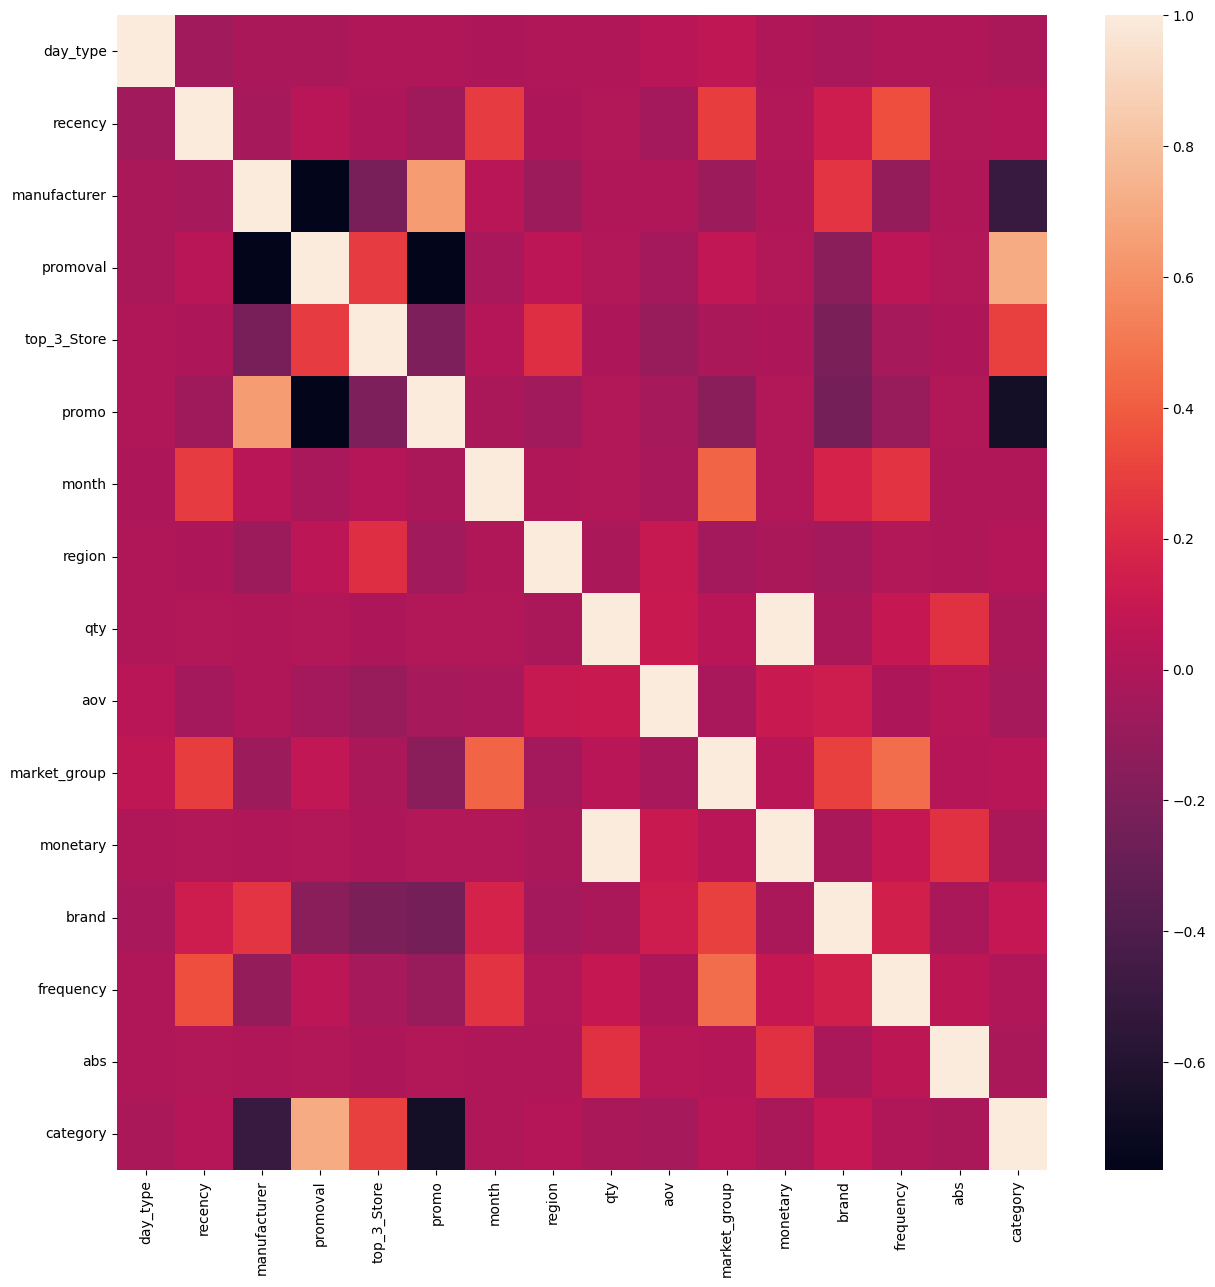

In [ ]:
plt.figure(figsize=(15, 15))  # You can adjust the dimensions as needed
sns.heatmap(X_train.corr(), annot=False)
plt.show()

In [ ]:
# Generate prediction features (for blind test)
predict_features = test_history.merge(trans_features, on='id', how='left')
predict_features.recency.fillna(365, inplace=True)
predict_features.frequency.fillna(0, inplace=True)
predict_features.monetary.fillna(0, inplace=True)

predict_features = predict_features.merge(promos, how='left', left_on='promo', right_on='promo')
predict_features['top_3_Store'] = predict_features.apply(mark_top_3_stores, axis=1, top_stores=top_3_stores)
predict_features['aov'] = predict_features['monetary']/predict_features['tot_ord']
predict_features['ord_per_month'] = predict_features['tot_ord']/predict_features['month']
predict_features['ord_per_quarqter'] = predict_features['tot_ord']/predict_features['quarter']
predict_features['abs'] = predict_features['qty']/predict_features['id']
X_predict = predict_features[x_cols]

predict_out = predict_features[['id', 'active']].copy()

In [ ]:
X_predict.fillna(0,inplace=True)
X_predict.isnull().sum()

day_type        0
recency         0
manufacturer    0
promoval        0
top_3_Store     0
promo           0
month           0
region          0
qty             0
aov             0
market_group    0
monetary        0
brand           0
frequency       0
abs             0
category        0
dtype: int64

In [ ]:
X_train_encoded = pd.get_dummies(X_train, columns=['region', 'promo', 'manufacturer', 'brand','category'], drop_first=True, dtype = int)
X_test_encoded = pd.get_dummies(X_test, columns=['region', 'promo', 'manufacturer', 'brand','category'], drop_first=True, dtype = int)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_predict_encoded = pd.get_dummies(X_predict, columns=['region', 'promo', 'manufacturer', 'brand','category'], drop_first=True, dtype = int)
X_predict_encoded = X_predict_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded[X_train_encoded.columns]
X_predict_encoded = X_predict_encoded[X_train_encoded.columns]

In [ ]:
X_train_encoded

,day_type,recency,promoval,top_3_Store,month,qty,aov,market_group,monetary,frequency,...,brand_1234009542,brand_1386413202,brand_1429623935,category_20487740,category_42760698,category_51006740,category_55115791,category_56844954,category_75228190,category_81382162
9807,0.147488,354.0,2.00,0,12.0,739.0,5.294846,57.0,3266.919922,0.153203,...,1,0,0,0,0,0,0,0,1,0
7599,0.164859,354.0,2.00,1,12.0,693.0,3.703644,51.0,1707.380005,0.121127,...,1,0,0,0,0,0,0,0,1,0
5546,0.197279,345.0,0.75,0,12.0,6616.0,3.054490,57.0,2245.050049,0.204482,...,0,1,0,0,1,0,0,0,0,0
7982,0.196809,328.0,0.75,0,9.0,644.0,5.515293,64.0,2073.750000,0.042135,...,0,1,0,0,1,0,0,0,0,0
12861,0.369782,352.0,1.50,1,11.0,2331.0,4.677325,68.0,7956.129883,0.182891,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374,0.040892,348.0,2.00,1,12.0,2406.0,4.545985,59.0,4891.479980,0.269972,...,1,0,0,0,0,0,0,0,1,0
11825,0.121951,349.0,2.00,0,12.0,605.0,3.985144,54.0,1797.299927,0.191045,...,1,0,0,0,0,0,0,0,1,0
14740,0.280982,355.0,0.75,0,12.0,1488.0,4.440429,65.0,3618.949951,0.247934,...,0,1,0,0,1,0,0,0,0,0
9818,0.383621,344.0,1.00,0,9.0,312.0,2.715345,47.0,629.960022,0.049861,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

x_cols.remove('promo')
x_cols.remove('manufacturer')
x_cols.remove('brand')
x_cols.remove('region')
x_cols.remove('category')
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data (only on the columns specified in x_cols)
scaler.fit(X_train_encoded[x_cols])

# Update the training data directly
X_train_encoded[x_cols] = scaler.transform(X_train_encoded[x_cols])

# Transform and update the test data directly
X_test_encoded[x_cols] = scaler.transform(X_test_encoded[x_cols])

# Transform and update the prediction data directly
X_predict_encoded[x_cols] = scaler.transform(X_predict_encoded[x_cols])

In [ ]:
X_train_encoded

,day_type,recency,promoval,top_3_Store,month,qty,aov,market_group,monetary,frequency,...,brand_1234009542,brand_1386413202,brand_1429623935,category_20487740,category_42760698,category_51006740,category_55115791,category_56844954,category_75228190,category_81382162
9807,-0.886640,0.380413,1.553137,-0.695127,0.344280,-0.020696,0.987262,0.001648,-0.015707,-0.474852,...,1,0,0,0,0,0,0,0,1,0
7599,-0.805557,0.380413,1.553137,1.438587,0.344280,-0.021204,-0.287783,-0.537026,-0.021778,-0.727219,...,1,0,0,0,0,0,0,0,1,0
5546,-0.654231,-0.852990,-0.819167,-0.695127,0.344280,0.044243,-0.807957,0.001648,-0.019685,-0.071411,...,0,1,0,0,1,0,0,0,0,0
7982,-0.656427,-3.182752,-0.819167,-0.695127,-1.849532,-0.021746,1.163909,0.630100,-0.020352,-1.348699,...,0,1,0,0,1,0,0,0,0,0
12861,0.150962,0.106323,0.604215,1.438587,-0.386991,-0.003105,0.492437,0.989216,0.002546,-0.241281,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374,-1.384196,-0.441856,1.553137,1.438587,0.344280,-0.002276,0.387193,0.181205,-0.009383,0.443846,...,1,0,0,0,0,0,0,0,1,0
11825,-1.005837,-0.304811,1.553137,-0.695127,0.344280,-0.022177,-0.062215,-0.267689,-0.021428,-0.177129,...,1,0,0,0,0,0,0,0,1,0
14740,-0.263533,0.517457,-0.819167,-0.695127,0.344280,-0.012420,0.302610,0.719879,-0.014337,0.270454,...,0,1,0,0,1,0,0,0,0,0
9818,0.215554,-0.990035,-0.344707,-0.695127,-1.849532,-0.025414,-1.079717,-0.896142,-0.025972,-1.287908,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
#X_train_scaled_dummies = X_train
#X_test_scaled_dummies = X_test_scaled
#X_predict_scaled_dummies = X_predict_scaled

# Build Model

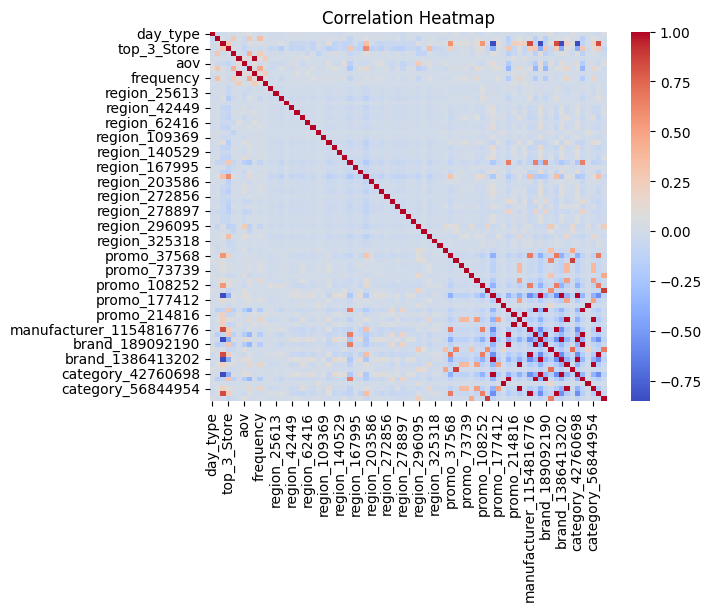

In [ ]:
import seaborn as sns
sns.heatmap(X_train_encoded.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X_train_encoded.shape

(19998, 75)

In [ ]:
X_train_encoded.head()

,day_type,recency,promoval,top_3_Store,month,qty,aov,market_group,monetary,frequency,...,brand_1234009542,brand_1386413202,brand_1429623935,category_20487740,category_42760698,category_51006740,category_55115791,category_56844954,category_75228190,category_81382162
9807,-0.886640,0.380413,1.553137,-0.695127,0.344280,-0.020696,0.987262,0.001648,-0.015707,-0.474852,...,1,0,0,0,0,0,0,0,1,0
7599,-0.805557,0.380413,1.553137,1.438587,0.344280,-0.021204,-0.287783,-0.537026,-0.021778,-0.727219,...,1,0,0,0,0,0,0,0,1,0
5546,-0.654231,-0.852990,-0.819167,-0.695127,0.344280,0.044243,-0.807957,0.001648,-0.019685,-0.071411,...,0,1,0,0,1,0,0,0,0,0
7982,-0.656427,-3.182752,-0.819167,-0.695127,-1.849532,-0.021746,1.163909,0.630100,-0.020352,-1.348699,...,0,1,0,0,1,0,0,0,0,0
12861,0.150962,0.106323,0.604215,1.438587,-0.386991,-0.003105,0.492437,0.989216,0.002546,-0.241281,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
X_train_encoded.fillna(0,inplace=True)
X_train_encoded.isnull().sum()

day_type             0
recency              0
promoval             0
top_3_Store          0
month                0
                    ..
category_51006740    0
category_55115791    0
category_56844954    0
category_75228190    0
category_81382162    0
Length: 75, dtype: int64

In [ ]:
X_train_encoded.columns

Index(['day_type', 'recency', 'promoval', 'top_3_Store', 'month', 'qty', 'aov',
       'market_group', 'monetary', 'frequency', 'abs', 'region_7892',
       'region_25613', 'region_36431', 'region_36835', 'region_42449',
       'region_42773', 'region_48013', 'region_62416', 'region_67664',
       'region_103373', 'region_109369', 'region_115119', 'region_132336',
       'region_140529', 'region_157815', 'region_165933', 'region_167995',
       'region_180548', 'region_191747', 'region_203586', 'region_206022',
       'region_243820', 'region_272856', 'region_274861', 'region_276730',
       'region_278897', 'region_284893', 'region_293974', 'region_296095',
       'region_303057', 'region_323706', 'region_325318', 'region_334402',
       'promo_32358', 'promo_37568', 'promo_65353', 'promo_69839',
       'promo_73739', 'promo_89784', 'promo_97335', 'promo_108252',
       'promo_170791', 'promo_176321', 'promo_177412', 'promo_200736',
       'promo_209524', 'promo_214816', 'manufacturer

In [ ]:
X_combined = pd.concat([X_train_encoded, X_test_encoded], ignore_index=True)

# Combine the labels
y_combined = pd.concat([y_train, y_test], ignore_index=True)

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import GridSearchCV

#rf = RandomForestClassifier(random_state=42)

# Parameters for GridSearchCV
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [5, 10, 15],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

# Setup the GridSearchCV
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

# Fit the model
#grid_search.fit(X_train_encoded, y_train)
#print("Best parameters found: ", grid_search.best_params_)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
#model = grid_search.best_estimator_
model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=1, random_state=42)
model.fit(X_train_encoded, y_train)
#y_pred = model.predict(X_test_encoded)
#print(classification_report(y_test, y_pred))

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300,
                       random_state=42)

In [ ]:
print('Test Accuracy: {:.2f}'.format(model.score(X_test_encoded, y_test)))
print('Test AUC: {:.2f}'.format(roc_auc_score(y_test, model.predict_proba(X_test_encoded)[:, 1])))

Test Accuracy: 0.80
Test AUC: 0.69


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test_encoded)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[3068  106]
 [ 709  117]]


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
#model = grid_search.best_estimator_
model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=1, random_state=42)
model.fit(X_combined, y_combined)
#y_pred = model.predict(X_test_encoded)
#print(classification_report(y_test, y_pred))

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300,
                       random_state=42)

# Generate Prediction

In [ ]:
predict_out.head()

,id,active
0,250462324156,NaN
1,61214568335,NaN
2,274776763999,NaN
3,91546215019,NaN
4,220718580189,NaN


In [ ]:
X_predict_encoded.isnull().sum()

day_type             0
recency              0
promoval             0
top_3_Store          0
month                0
                    ..
category_51006740    0
category_55115791    0
category_56844954    0
category_75228190    0
category_81382162    0
Length: 75, dtype: int64

In [ ]:
predict_out['active'] = model.predict_proba(X_predict_encoded)[:, 1]
predict_out.head()

,id,active
0,250462324156,0.224569
1,61214568335,0.157255
2,274776763999,0.273897
3,91546215019,0.194080
4,220718580189,0.177493


In [ ]:
predict_out.to_csv('predict_AUC_69_RF_DF_upd.csv', header=True, index=False)
predict_out.head()

,id,active
0,250462324156,0.224569
1,61214568335,0.157255
2,274776763999,0.273897
3,91546215019,0.194080
4,220718580189,0.177493


In [ ]:
# This will download your prediction files
from google.colab import files
files.download('predict_AUC_69_RF_DF_upd.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>